Value iteration converged after 5 iterations.
goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4
goal_reached 2
goal_reached 1
goal_reached 1
goal_reached 2
goal_reached 3
goal_reached 4
goal_reached 4


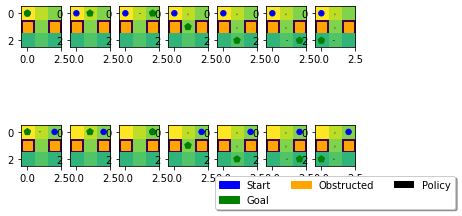

In [12]:
import sys
sys.path.append("..")
import numpy as np
from env.grid_world_multitask import GridWorld
from algorithms.dynamic_programming_multitask import value_iteration
from utils.plots_multitask import plot_gridworld, plot_gridworld_subtasks
import copy

###########################################################
#          Run value iteration on a grid world            #
###########################################################

# # specify world parameters
num_cols = 3
num_rows = 3
obstructions = np.array([[1,0],[1,2]])
start_state = np.array([[0,0], [0,2]])
start_states_plot = start_state
goal_states = np.array([[0,0], [0,1], [0,2], [1, 1], [2, 1], [2,2], [2, 0]])
goal_states_plot = goal_states

# specify world parameters
# num_cols = 4
# num_rows = 5
# all_states = [ [i, j] for j in range(num_cols) for i in range(num_rows)]
# obstructions = [[2,1],[2,2]]
# goal_states = np.array([ el for el in all_states if el not in obstructions])
# obstructions = np.array(obstructions)
# start_states_plot = goal_states[4:5]
# goal_states_plot = goal_states[5:]

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states)
gw.add_obstructions(
                    obstructed_states=obstructions,
                    # bad_states=bad_states,
                    # restart_states=restart_states
                    )
gw.add_rewards(
               step_reward=0,
               goal_reward=1,
               bad_state_reward=0,
               restart_state_reward=0)
gw.add_transition_probability(p_good_transition=1.,
                              bias=0.)
gw.add_discount(discount=0.9)
model = gw.create_gridworld()

# print('model created')

# solve with value iteration
value_function, policy = value_iteration(model, maxiter=100)

# print('policy created')

# print('policy', policy.shape)

# plot the results
path = "../doc/imgs/value_iteration.png"
plot_gridworld(model, value_function=value_function, policy=policy,
               # title="Value iteration",
               path=path,
               start_states=start_states_plot, goal_states=goal_states_plot)

# print('plot saved')

In [13]:
value_function = value_function[:, :, 0]

In [14]:
value_function.shape

(10, 10)

In [15]:
from utils.helper_functions import row_col_to_seq, seq_to_col_row

In [16]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))

    # plot the results
    path = "../doc/imgs/value_iteration.png"
    plot_gridworld(model, value_function=val_hat_, policy=pi_hat,
                   # title="Value iteration",
                   path=path,
                   start_states=start_states_plot, goal_states=goal_states_plot)

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler

# Devide

In [18]:
# mean, std = 0., 1.
mean, std = np.mean(goal_states, axis=0), np.std(goal_states, axis=0)
device = 'cpu'

In [19]:
std

array([0.9258201 , 0.75592895])

In [20]:
class ValueDataset(torch.utils.data.Dataset):
    def __init__(self, value_function, start_states, goal_states, model, mean=None, std=None):
        self.value_function = value_function
        self.start_states = start_states
        self.goal_states = goal_states
        self.start_states_seq = row_col_to_seq(self.start_states, model.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, model.num_cols)
        self.start_states = (self.start_states - mean) / std
        self.goal_states = (self.goal_states - mean) / std
        self.start_dict = {k: v for k, v in zip(self.start_states_seq, self.start_states)}
        self.goal_dict = {k: v for k, v in zip(self.goal_states_seq, self.goal_states)}
        
    def __len__(self):
        return len(self.start_states_seq)*len(self.goal_states_seq)

    def __getitem__(self, idx):
        s_idx = idx % len(self.goal_states_seq) #start index
        g_idx = idx // len(self.goal_states_seq) #goal index
        s = self.start_states_seq[s_idx]
        g = self.goal_states_seq[g_idx]
        if s==g:
            g = self.goal_states_seq[np.random.randint(len(self.goal_states_seq)) % len(self.goal_states_seq)]
        v_x = self.value_function[s, g]
        x = np.hstack([self.start_dict[s], self.goal_dict[g]])
        xsm = []
        xmg = []
        v_xsm = []
        v_xmg = []
        for m in self.start_states_seq:
            xsm.append(np.hstack([self.start_dict[s], self.goal_dict[m]]))
            xmg.append(np.hstack([self.start_dict[m], self.goal_dict[g]]))
            v_xsm.append(self.value_function[s, m])
            v_xmg.append(self.value_function[m, g])

        xsm = np.array(xsm)
        xmg = np.array(xmg)
        v_xsm = np.array(v_xsm)
        v_xmg = np.array(v_xmg)
        return x, xsm, xmg, v_x, v_xsm, v_xmg 

In [21]:
# Prepare dataset
dataset = ValueDataset(value_function,
                       start_states=goal_states, goal_states=goal_states,
                       model=model, 
                       mean=mean, std=std
                      )
trainloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

In [22]:
class DC(nn.Module):
    def __init__(self, middle_dim=8, n_states=7, states=None, mean=0, std=1, device='cpu'):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(4, middle_dim),
              nn.LeakyReLU(),
              nn.Linear(middle_dim, 1),
#               nn.LeakyReLU(),
#               nn.Linear(64, 1)
        )
        
        middle_proba_dim = 16
        self.proba = nn.Sequential(
            nn.Linear(4, middle_proba_dim),
            nn.LeakyReLU(),
            nn.Linear(middle_proba_dim, middle_proba_dim),
            nn.LeakyReLU(),
            nn.Linear(middle_proba_dim, n_states+1),
            nn.Softmax()
        )
        
        self.states_original = states
        self.mean = mean
        self.std = std
        self.states = (self.states_original - mean) / std
        
    def prepare_data(self, s, g):
        x = np.hstack([s, g])
        x_s_m = []
        x_m_g = []
        for m in self.states:
            xsm = np.hstack([s, m])
            xmg = np.hstack([m, g])
            x_s_m.append(xsm)
            x_m_g.append(xmg)
        
        x_s_m = np.array(x_s_m)
        x_m_g = np.array(x_m_g)
        
        data = torch.tensor(x[None]).float().to(device), \
        torch.tensor(x_s_m[None]).float().to(device), torch.tensor(x_m_g[None]).float().to(device)
        
        return data
        

    def forward(self, data):
        x, x_s_m, x_m_g = data
        p = self.proba(x)
        y_x = self.layers(x)
        y_xsm = self.layers(x_s_m)
        y_xmg = self.layers(x_m_g)
        subpaths = y_xsm[:, :, 0]*y_xmg[:, :, 0]
        paths = torch.cat([y_x, subpaths], 1)
        return p, paths, y_x, y_xsm, y_xmg


In [23]:
# Initialize the MLP
mlp = DC(states=goal_states, 
         mean=mean, std=std,
         n_states=len(goal_states),
        )

# Define the loss function and optimizer
# loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=1e-2)

In [24]:
# Run the training loop
for epoch in range(0, 10000): # 5 epochs at maximum
    # Print epoch
#     print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = data
        
        x, x_s_m, x_m_g, v_x, v_xsm, v_xmg  = x.float(), x_s_m.float(), x_m_g.float(), v_x.float(), v_xsm.float(), v_xmg.float()
        inputs = x, x_s_m, x_m_g
        v_x, v_xsm, v_xmg = v_x.unsqueeze(-1), v_xsm.unsqueeze(-1), v_xmg.unsqueeze(-1)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        p, outputs, y_x, y_xsm, y_xmg = mlp(inputs)

        # Compute loss
        loss_v_x = torch.abs(y_x-v_x)
        loss_v_xsm = torch.abs(y_xsm-v_xsm)
        loss_v_xmg = torch.abs(y_xmg-v_xmg)
        loss_subgoal = loss_v_xsm + loss_v_xmg
        loss_v = (p[:, :1].detach()*loss_v_x).sum(dim=1).mean() + (p[:, 1:].unsqueeze(-1).detach()*loss_subgoal).sum(1).mean() 
        
        entropy = (p*torch.log(p)).sum(1).mean()
        v_list = torch.cat([v_x.unsqueeze(-1), v_xsm*v_xmg], 1)
        p_loss = -(p.unsqueeze(-1)*v_list).sum(1).mean() + entropy
        
        loss = p_loss + loss_v

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
    
    if epoch % 500 == 0:
        print('Loss: %.3f' % (current_loss ))
        print('v_list argmax', v_list[:, :, 0].argmax(1))
        print('p argrmax', p.argmax(-1))
        print('v_list', v_list[0, :, 0])
        print('p', p[0])
#         print('loss_v_x', loss_v_x[0])
#         print('loss_subgoal', loss_subgoal[0])
#         print('loss_v_xsm', loss_v_xsm[0])
#         print('loss_v_xmg', loss_v_xmg[0])
#         print('loss_vsg_vsmg', loss_vsg_vsmg[0])
#         print('x_s_m', x_s_m[0])
#         print('x_m_g', x_m_g[0])
#         print('idx', idx)
#         print('m', mlp.states_original[idx-1:idx])
#         seq_to_col_row()
#         abs_argmax = torch.abs(outputs.detach()-v_x).argmax(-1)
#         print('argmax abs', abs_argmax)
#         abs_argmax = torch.abs(outputs[:, 1:].detach()-v_x).argmax(-1)
#         print('true_dif[:, abs_argmax]', true_dif[torch.arange(len(argmax)), argmax])
        
    current_loss = 0.0

# Process is complete.
print('Training process has finished.')

/Users/ivananokhin/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Loss: -1.832
v_list argmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax tensor([0, 1, 0, 3, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 3, 0, 1, 0,
        1, 3, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0,
        0])
v_list tensor([0.9000, 0.5905, 0.7290, 0.5905, 0.9000, 0.9000, 0.7290, 0.7290])
p tensor([0.1433, 0.1356, 0.0949, 0.1398, 0.1364, 0.1318, 0.1147, 0.1034],
       grad_fn=<SelectBackward>)
Loss: -2.682
v_list argmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax tensor([4, 0, 0, 0, 4, 0, 0, 3, 4, 0, 0, 0, 4, 0, 0, 0, 5, 0, 0, 0, 4, 0, 0, 6,
        5, 0, 4, 4, 4, 0, 0, 0, 0, 4, 0, 4, 4, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 0,
        0])
v_list tensor([0.9000, 0.4783, 0.5905, 0.4783, 0.7

Loss: -2.745
v_list argmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax tensor([0, 5, 5, 5, 2, 5, 5, 0, 2, 5, 0, 5, 0, 5, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5,
        2, 0, 4, 5, 0, 0, 4, 0, 2, 2, 5, 4, 0, 0, 0, 0, 4, 0, 0, 4, 0, 5, 0, 0,
        0])
v_list tensor([0.8100, 0.8100, 0.8100, 0.6561, 0.8100, 0.6561, 0.5314, 0.5314])
p tensor([0.1489, 0.1225, 0.1316, 0.1271, 0.1269, 0.1269, 0.1043, 0.1118],
       grad_fn=<SelectBackward>)
Loss: -2.745
v_list argmax tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
p argrmax tensor([5, 0, 0, 5, 4, 2, 0, 5, 4, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0,
        2, 0, 0, 5, 0, 0, 5, 5, 4, 0, 0, 2, 0, 0, 0, 0, 4, 0, 5, 4, 2, 0, 2, 4,
        5])
v_list tensor([0.8100, 0.4305, 0.5314, 0.4305, 0.6

In [256]:
predict = []
for x in X:
    s = (x[:2] - mean) / std
    g = (x[2:] - mean) / std
    data = mlp.prepare_data(s, g)
    p, v, y_x, y_xsm, y_xmg = mlp(data)
#     print('p', p)
    idx = p.argmax()
    print('idx', idx)
    print('m', mlp.states_original[idx-1:idx])
#     print(mlp.get_propa(data))
    predict.append(v.detach().numpy()[:, 0])

predict = np.array(predict)[:, 0]
    
    

idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0)
m []
idx tensor(0

In [266]:
# start_state_sub = np.array([[0,0], [0,2], [2,2], [2, 0], [0,0], [0,2], [2,2], [2, 0], [0,0]])
# goal_states_sub = np.array([[2,2], [2, 0], [0,0], [0,2], [0,2], [0,0], [2, 0], [2,2], [0,1]])
# subgoal_states_sub = []
start_state_sub = goal_states[8:9]
goal_states_sub = goal_states[:6]
start_state_sub = np.tile(start_state_sub, (len(goal_states_plot), 1))
subgoal_states_sub = []

for s, g in zip(start_state_sub, goal_states_sub):
    s = (s - mean) / std
    g = (g - mean) / std
    data = mlp.prepare_data(s, g)
    p, *_ = mlp(data)
    idx = p.argmax()
    print('idx', idx)
    if idx == 0:
        subgoal_states_sub.append([None])
    else:
        subgoal_states_sub.append(mlp.states_original[idx-1:idx])
        
print(start_state_sub.shape, goal_states_sub.shape, len(subgoal_states_sub))


idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
idx tensor(0)
(13, 2) (6, 2) 6


In [267]:
start_state_sub

array([[4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1],
       [4, 1]])

In [268]:
goal_states_sub

array([[0, 0],
       [1, 0],
       [2, 0],
       [3, 0],
       [4, 0],
       [0, 1]])

In [269]:
subgoal_states_sub

[[None], [None], [None], [None], [None], [None]]

In [270]:
[[None]*len(goal_states_sub)]

[[None, None, None, None, None, None]]

In [271]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,20)

In [272]:
def find_plot_pi_hat(y_hat, model, index):
    pi_hat = np.ones((model.num_states, model.num_states, 1))
    val_hat_ = np.zeros((model.num_states, model.num_states, 1))
    val_hat_[index[:, 0], index[:, 1], 0] = y_hat

    # compute the policy
    for state in range(model.num_states):
        for goal in model.goal_states_seq:
            P = copy.deepcopy(model.P)
            P[goal, :, :] = 0
            P[goal, model.num_states - 1, :] = 1
            pi_hat[state, goal] = np.argmax(np.sum(val_hat_[:, goal, :] * P[state,:,:],0))
    
    return pi_hat

No handles with labels found to put in legend.


goal_reached 5
goal_reached 4
goal_reached 3
goal_reached 2
goal_reached 1


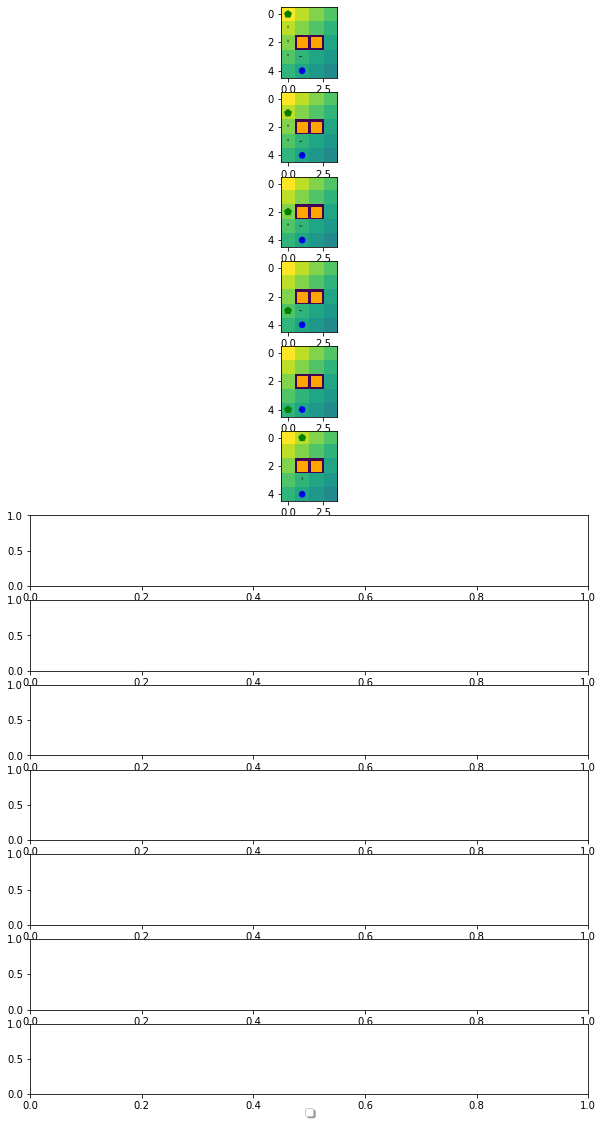

In [273]:
pi_hat = find_plot_pi_hat(predict, model, index)
# pi_hat
plot_gridworld_subtasks(model, value_function=value_function, policy=policy, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, 
                       subgoal_states=subgoal_states_sub,
                       )

No handles with labels found to put in legend.


goal_reached 5
goal_reached 4
goal_reached 3
goal_reached 2
goal_reached 1


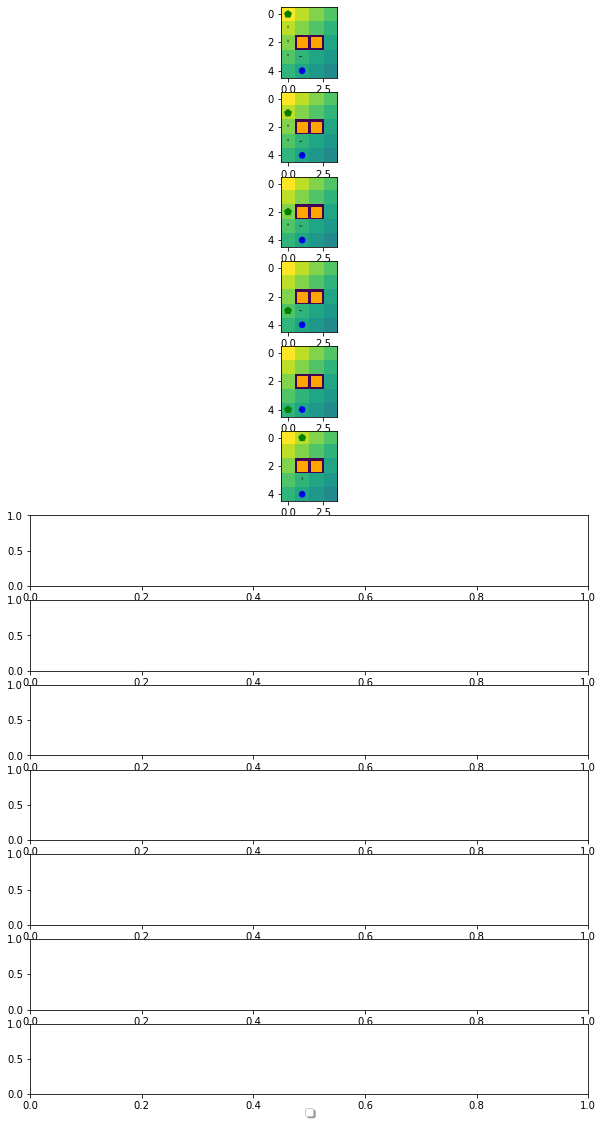

In [274]:
plot_gridworld_subtasks(model, value_function=value_function, policy=policy, path=path,
                       start_states=start_state_sub, goal_states=goal_states_sub, 
                        subgoal_states=[[None]]*len(goal_states_sub),)